In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords

from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models.keyedvectors import KeyedVectors

from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
import math
import warnings

In [48]:
train_df_master = pd.read_csv('Train_data_cleaned.csv')
test_df_master = pd.read_csv('Test_data_cleaned.csv')

In [49]:
train_df = train_df_master.copy()
print('Training data has {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))

test_df = test_df_master.copy()
print('Testing data has {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))

Training data has 3235 rows and 2 columns
Testing data has 1387 rows and 1 columns


In [50]:
# define the training and testing lengths to keep a track on encoded data
train_length = len(train_df)
test_length = len(test_df)

### Functions for building the data for LSTM model

In [51]:
""" Although the data in this file is already cleaned, we still perform a double check """

def tokenize(text):
    stop_words = stopwords.words('english')    
    
    tokenized_text = []
    
    for txt in text:
        words = txt.split(' ')
        tokenized_string = ''

        for word in words:
            # check for name handles and unwanted text
            if word[0] != '@' and word not in stop_words:
                # if the word is a hastag, remove #
                if word[0] == '#':
                    word = word[1:]

                tokenized_string += word + ' '

        tokenized_text.append(tokenized_string)
    
    return tokenized_text

In [52]:
""" encode text -> translate text to a sequence of numbers """

def encode_text(text):
    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=" ", lower=True)
    tokenizer.fit_on_texts(text)
    
    return tokenizer, tokenizer.texts_to_sequences(text)

In [53]:
""" Apply padding to dataset and convert labels (-1, 0, 1) to bitmaps """

def format_data(encoded_text, max_length, sent_labels):
    x = pad_sequences(encoded_text, maxlen= max_length, padding='post')
    y = []
    
    for label in sent_labels:
        bit_vec = np.zeros(3)
        bit_vec[label+1] = 1
        y.append(bit_vec)
        
    y = np.asarray(y)
    return x, y

In [54]:
""" create weight matrix from pre trained embeddings """

def create_weight_matrix(vocab, raw_embeddings):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, 300))
    
    for word, idx in vocab.items():
        if word in raw_embeddings:
            weight_matrix[idx] = raw_embeddings[word]
    
    return weight_matrix

In [55]:
""" Define f1 score to be passed as metric for model evaluation """



' Define f1 score to be passed as metric for model evaluation '

### Defining the model

In [56]:
""" final model """
def final_model(weight_matrix, vocab_size, max_length):
    embedding_layer = Embedding(vocab_size, 300, weights=[weight_matrix], input_length=max_length, trainable=True, 
                                mask_zero=True)
    model = Sequential()
    model.add(embedding_layer)
    
    model.add(Bidirectional(LSTM(256, dropout=0.5, return_sequences=True)))
    model.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    
    model.add(Dense(64, activation = 'softmax'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

### Preparing Data

In [57]:
""" Tokenize all the training and testing text """

tokenized_text = tokenize(train_df['text'])
tokenized_text += tokenize(test_df['text'])

max_length = math.ceil(sum([len(s.split(" ")) for s in tokenized_text])/len(tokenized_text))

tokenizer, encoded_text = encode_text(tokenized_text)

max_length, len(tokenized_text)

(22, 4622)

In [58]:
""" Apply padding and format data """

x, y = format_data(encoded_text[:train_length], max_length, train_df['sentiment_class'])
print('For train data: ', len(x), len(y))

x_test = pad_sequences(encoded_text[train_length:], maxlen= max_length, padding='post')
print('For test data: ', len(x_test))

For train data:  3235 3235
For test data:  1387


In [59]:
""" Clearing vocabulary """

vocab = tokenizer.word_index
vocab, len(vocab)

({'day': 1,
  'happy': 2,
  'mothers': 3,
  'mothersday': 4,
  'mother': 5,
  'mum': 6,
  'love': 7,
  'mums': 8,
  'today': 9,
  'amazing': 10,
  'hope': 11,
  'happymothersday': 12,
  'thank': 13,
  'world': 14,
  'wonderful': 15,
  'one': 16,
  'best': 17,
  'know': 18,
  'safe': 19,
  'beautiful': 20,
  'stay': 21,
  'family': 22,
  'much': 23,
  'everyone': 24,
  'like': 25,
  'wish': 26,
  'mom': 27,
  'always': 28,
  'time': 29,
  'every': 30,
  'see': 31,
  'lovely': 32,
  'women': 33,
  'special': 34,
  'would': 35,
  'motheringsunday': 36,
  'uk': 37,
  'celebrate': 38,
  'children': 39,
  'life': 40,
  'mummy': 41,
  'great': 42,
  'may': 43,
  'get': 44,
  'year': 45,
  'home': 46,
  'everything': 47,
  'wishing': 48,
  'still': 49,
  'keep': 50,
  'good': 51,
  'woman': 52,
  'covid': 53,
  'sunday': 54,
  'times': 55,
  'say': 56,
  'make': 57,
  'could': 58,
  'even': 59,
  'without': 60,
  'well': 61,
  'thanks': 62,
  'take': 63,
  'kids': 64,
  'also': 65,
  'people':

In [45]:
""" Load w2v raw embeddings """

raw_embeddings = KeyedVectors.load_word2vec_format('model_swm_300-6-10-low.w2v')
raw_embeddings

C:\Users\hp\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [61]:
""" Create the weight matrix """

weight_matrix = create_weight_matrix(vocab, raw_embeddings)
len(weight_matrix)

20185

### Start training the model

In [62]:
model = final_model(weight_matrix, len(vocab)+1, max_length)

history = model.fit(x, y, epochs = 20, validation_split = 0.1)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 2911 samples, validate on 324 samples
Epoch 1/20
2911/2911 [==============================] - 61s 21ms/step - loss: 1.0510 - acc: 0.5222 - val_loss: 1.0225 - val_acc: 0.5432
Epoch 2/20
2911/2911 [==============================] - 52s 18ms/step - loss: 1.0330 - acc: 0.5239 - val_loss: 1.0157 - val_acc: 0.5432
Epoch 3/20
2911/2911 [==============================] - 55s 19ms/step - loss: 1.0299 - acc: 0.5239 - val_loss: 1.0111 - val_acc: 0.5432
Epoch 4/20
2911/2911 [==============================] - 59s 20ms/step - loss: 1.0254 - acc: 0.5239 - val_loss: 1.0094 - val_acc: 0.5432
Epoch 5/20
2911/2911 [==============================] - 57s 20ms/step - loss: 1.0278 - acc: 0.5239 - val_loss: 1.0082 - val_acc: 0.5432
Epoch 6/20
2911/2911 [==============================] - 58s 20ms/step - loss: 1.0249 - acc: 0.5239 - val_loss: 1.0071 - val_acc: 0.5432
Epoch 7/20
2911/2911 [==============================] - 58s 20ms/step - loss: 1.0231 - acc: 0.5239 - val_loss: 1.0072 - val_acc: 0.5432
E

In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 300)           6055500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 22, 512)           1140736   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 22, 256)           656384    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total para

#### Check model on train data

In [64]:
train_pred_prob = model.predict(x)
train_pred_prob

array([[0.0882475 , 0.8274972 , 0.08425526],
       [0.09027632, 0.8239094 , 0.08581426],
       [0.08844285, 0.8267597 , 0.0847974 ],
       ...,
       [0.410406  , 0.1776412 , 0.41195288],
       [0.10871709, 0.7904058 , 0.10087708],
       [0.10697559, 0.7895691 , 0.10345537]], dtype=float32)

In [65]:
train_pred = [np.argmax(pred)-1 for pred in train_pred_prob]
len(train_pred)

3235

In [66]:
train_f1_score = f1_score(train_df['sentiment_class'], train_pred, average='weighted')

print('F1 Score: ', train_f1_score)
print()
print('Confusion Matrix: \n', confusion_matrix(train_df['sentiment_class'], train_pred))
print()
print('Classification Report: \n', classification_report(train_df['sentiment_class'], train_pred))

F1 Score:  0.6491385910227182

Confusion Matrix: 
 [[  76  151  542]
 [  32 1606   63]
 [  47  139  579]]

Classification Report: 
               precision    recall  f1-score   support

          -1       0.49      0.10      0.16       769
           0       0.85      0.94      0.89      1701
           1       0.49      0.76      0.59       765

   micro avg       0.70      0.70      0.70      3235
   macro avg       0.61      0.60      0.55      3235
weighted avg       0.68      0.70      0.65      3235



### Predicting Test data

In [67]:
test_pred_prob = model.predict(x_test)
test_pred_prob

array([[0.11414804, 0.77882886, 0.10702306],
       [0.41680935, 0.16466631, 0.41852432],
       [0.38082436, 0.24446228, 0.37471333],
       ...,
       [0.10348938, 0.7995221 , 0.09698845],
       [0.10343072, 0.79553   , 0.10103926],
       [0.37869585, 0.24746284, 0.37384132]], dtype=float32)

In [68]:
test_pred = [np.argmax(pred)-1 for pred in test_pred_prob]
len(test_pred)

1387

### Writing the submission

In [69]:
org_test_df = pd.read_csv('Dataset/test.csv')
org_test_df.head()

,id,original_text,lang,retweet_count,original_author
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg


,id,sentiment_class
0,1.246628e+18,0
1,1.245898e+18,1
2,1.244717e+18,-1
3,1.245730e+18,0
4,1.244636e+18,0


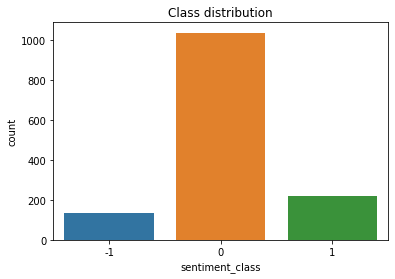

In [70]:
submission_df = org_test_df.copy()
submission_df.drop(['original_text', 'lang', 'retweet_count', 'original_author'], axis = 1, inplace = True)
submission_df['sentiment_class'] = test_pred

sns.countplot(submission_df['sentiment_class']).set_title('Class distribution')
submission_df.to_csv('Submission22.csv', index = False)
submission_df.head()